In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
# Carregar o datasets
df_salarios = pd.read_csv('./datasets/dataset_salarios.csv')

In [98]:
df_salarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [99]:
# Copiar dataframe para EDA
df_salarios_eda = df_salarios.copy()

In [100]:
# Copia para fazer o bucketing
df_salarios_bucketing = df_salarios.copy()

# EDA

In [101]:
# Detectar valores ausentes
df_salarios_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [102]:
df_salarios_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

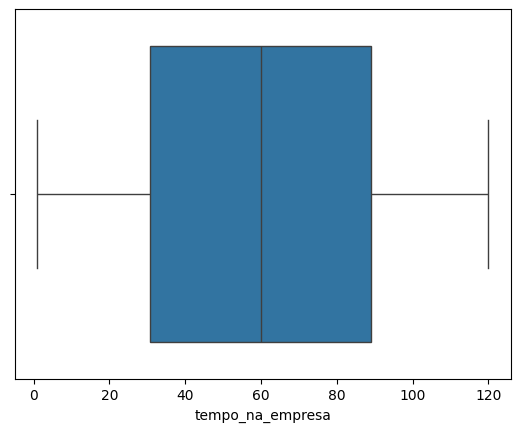

In [103]:
# Detectar outliers
sns.boxplot(data=df_salarios_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

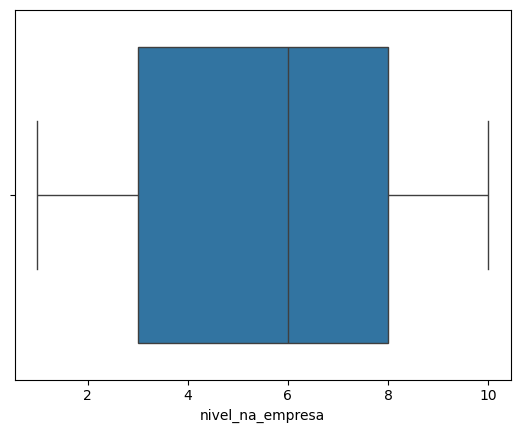

In [104]:
sns.boxplot(data=df_salarios_eda, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

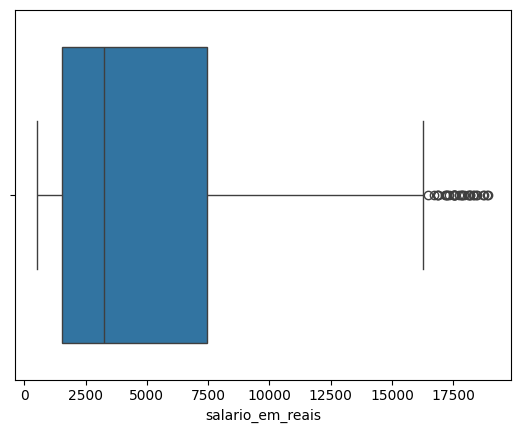

In [105]:
sns.boxplot(data=df_salarios_eda, x='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

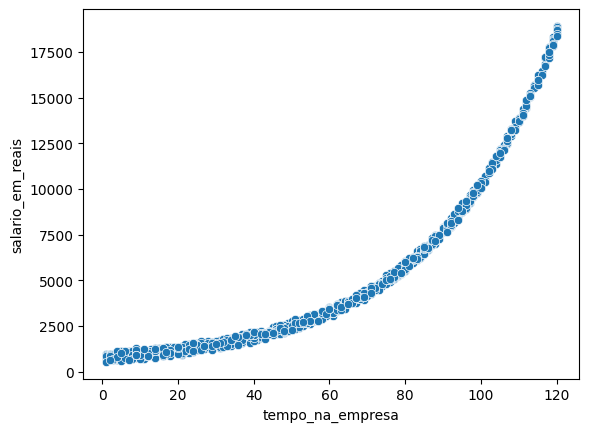

In [106]:
# Cruzamento de variáveis numéricas com salário em reais
sns.scatterplot(data=df_salarios_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

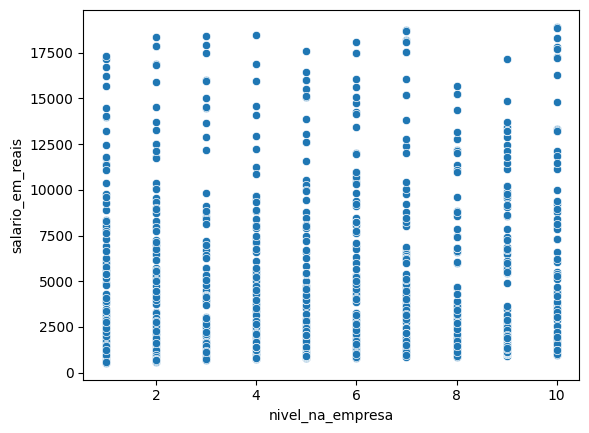

In [107]:
sns.scatterplot(data=df_salarios_eda, x='nivel_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

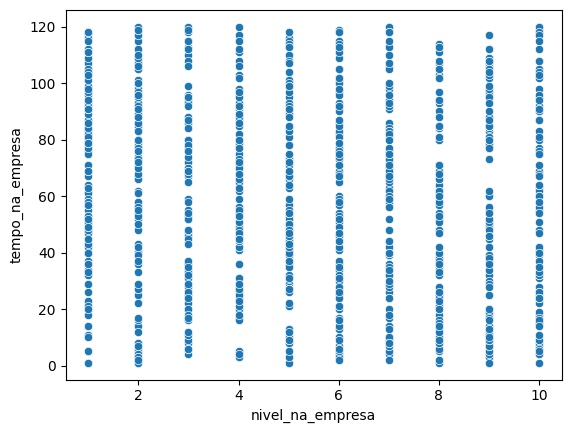

In [108]:
sns.scatterplot(data=df_salarios_eda, x='nivel_na_empresa', y='tempo_na_empresa')

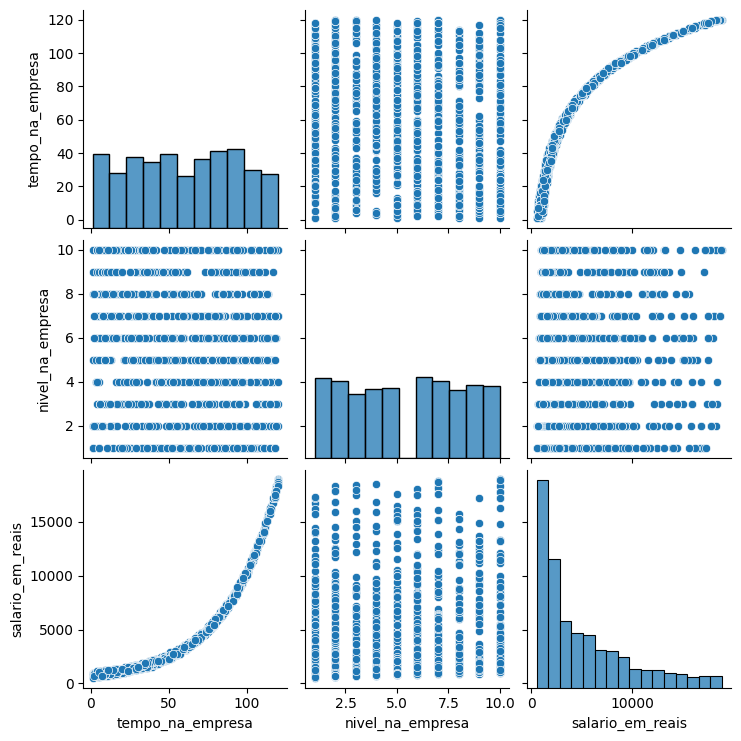

In [109]:
# Histograma das variáveis
sns.pairplot(df_salarios_eda)

<Axes: >

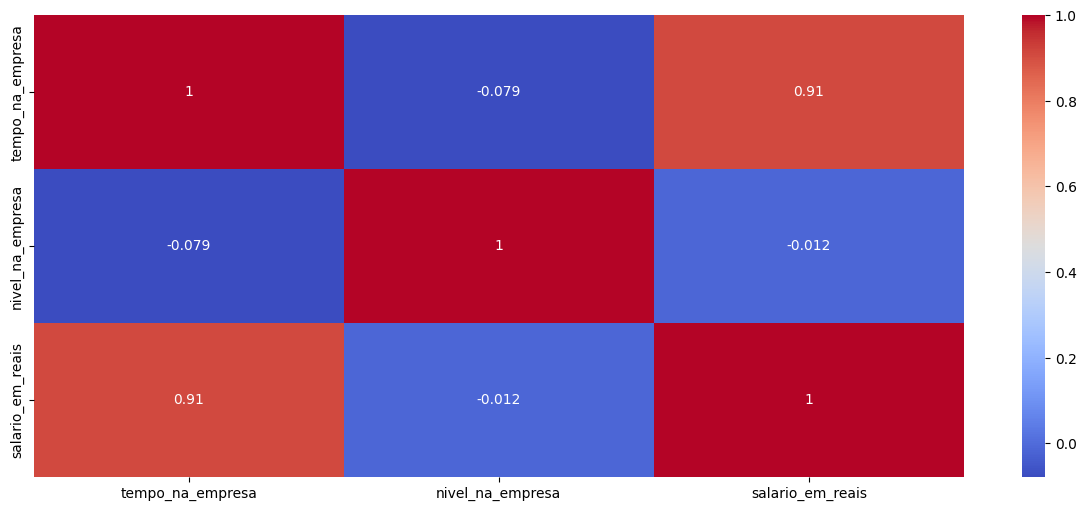

In [110]:
# Correlação - Pearson -> Usando correlação linear
plt.figure(figsize=(15, 6))
sns.heatmap(df_salarios_eda.corr(), annot=True, cmap='coolwarm')

<Axes: >

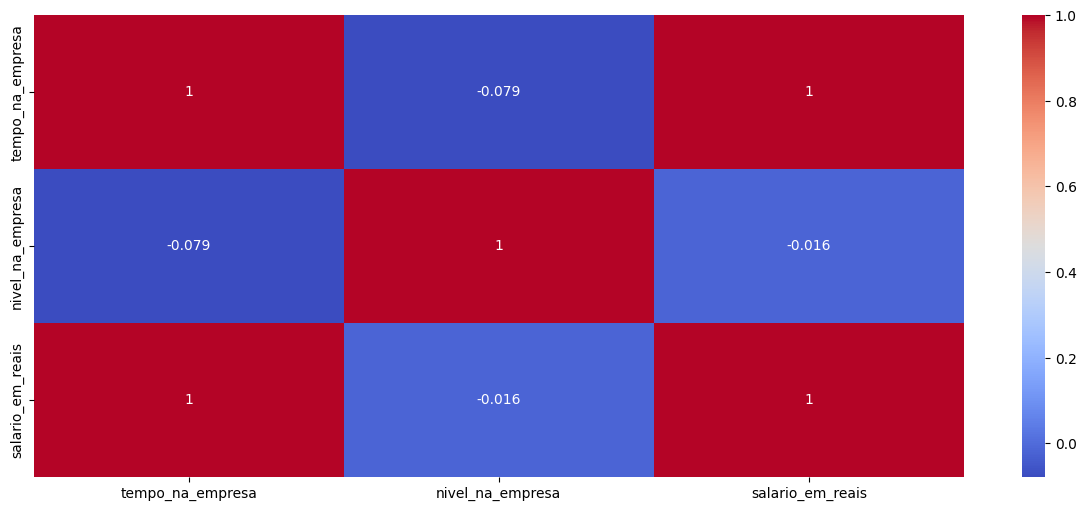

In [111]:
# Correlação - Spearman -> Usando correlação linear
plt.figure(figsize=(15, 6))
sns.heatmap(df_salarios_eda.corr('spearman'), annot=True, cmap='coolwarm')

<Axes: >

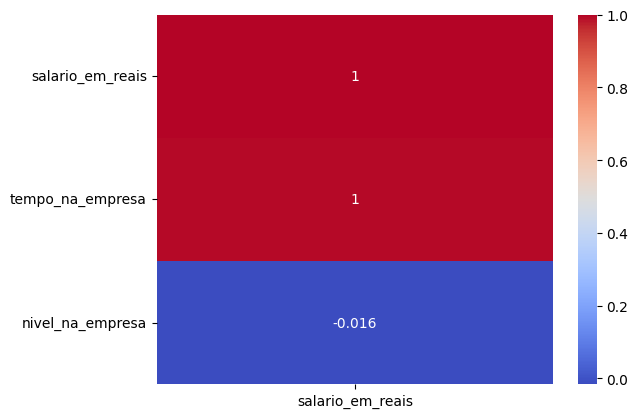

In [112]:
# Formato ranking
sns.heatmap(df_salarios_eda.corr('spearman')[['salario_em_reais']].sort_values(by=['salario_em_reais'], ascending=False), annot=True, cmap='coolwarm')

In [113]:
# Bucketing Tempo de casa
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129']

df_salarios_bucketing['escala_tempo'] = pd.cut(x=df_salarios_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)

In [114]:
df_salarios_bucketing.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

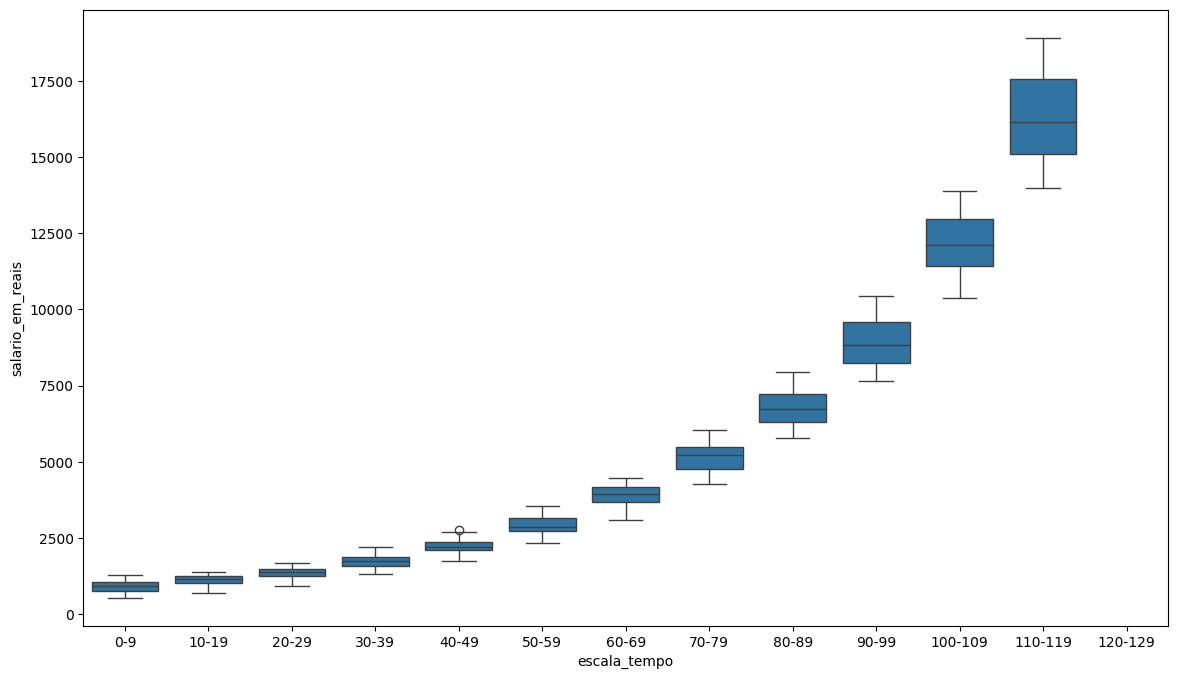

In [115]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_salarios_bucketing, x='escala_tempo', y='salario_em_reais')

# Treinar Modelo Linear

In [116]:
# Importar as bibliotecas
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

import numpy as np

In [117]:
# Criar o dataset de treino e teste
X = df_salarios.drop(columns=['salario_em_reais'], axis=1)
y = df_salarios['salario_em_reais']

In [118]:
# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [119]:

# Bloco para treinamento do modelo

# 1. Pipeline -> Padronização variáveis numéricas - tempo_na_empresa, nivel_na_empresa

# Nome das colunas
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar um ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', transformer_numericas, colunas_numericas)
])

# 2. Pipeline -> Pré-Processamento + Treinamento
model_regr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Armazenar RMSE - Treino e Teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Amazenar R² Score de Teste
r2_scores_fold_test = []

# Armazenar Resíduos
residuos = []

# Armazenar Predições
y_pred_total = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar o modelo no conjunto de treinamento
    model_regr.fit(X_train, y_train)
    
    # Faça predições nos conjuntos de treinamento e teste
    y_train_pred = model_regr.predict(X_train)
    y_test_pred = model_regr.predict(X_test)
    
    # Calcular o RMSE para os conjuntos de treinamento e teste
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_scores_fold_train.append(rmse_train)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    rmse_scores_fold_test.append(rmse_test)
    
    # Calcular o R² para os conjuntos de teste
    r2_test = r2_score(y_test, y_test_pred)
    r2_scores_fold_test.append(r2_test)
    
    # Calcular os resíduos para conjunto de teste
    residuos_test = np.array(y_test - y_test_pred)
    residuos.append(residuos_test)
    
    y_pred_total.append(y_test_pred)
    
    
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2_score_final = np.mean(r2_scores_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### Análise de Métricas - Modelo Linear

In [120]:
# Métricas
print(f"RMSE Treino: {rmse_train_final}")
print(f"RMSE Teste: {rmse_test_final}")
print(f"RMSE - diferença (%): {percentual_rmse_final}")
print(f"R² Score Teste: {r2_score_final}")

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
RMSE - diferença (%): 0.19218813844503052
R² Score Teste: 0.8261178870584762


### Análise de Resíduos - Modelo Linear

In [121]:
# Transformar resíduos na escala padrão -> (X - media) / desvio padrão

from scipy.stats import zscore

residuos_std = zscore(residuos)

In [122]:
residuos_std

array([ 5.95616525e-01, -7.24916727e-01, -6.46846433e-01,  8.64095533e-01,
       -5.33806156e-02, -7.61704833e-01,  6.80947606e-01,  1.45661295e+00,
        3.15407488e-01, -5.85616590e-01,  1.29483240e-01,  8.62850152e-01,
       -8.81408422e-01, -2.57676835e-01, -3.98447700e-01,  4.84215194e-01,
       -9.30147928e-01, -1.98427398e-01,  2.09007896e-01, -9.04965560e-01,
       -6.81287606e-02, -8.34446292e-01, -3.95656924e-01,  1.85180868e-01,
       -8.59767063e-01, -1.16014546e+00, -9.89137623e-01,  1.98282340e+00,
       -7.09136535e-01, -5.86755306e-01,  2.97904569e+00,  3.41834809e-01,
       -1.07716414e+00,  1.30248304e+00, -5.99662310e-01, -4.35883427e-01,
       -5.78726106e-01, -1.02611646e+00,  3.62850210e-01,  1.01353539e+00,
       -3.51902591e-01,  9.50243614e-01,  1.10020428e+00,  3.93453210e-01,
       -8.28856918e-02, -2.86114598e-01, -1.14814701e+00, -7.64435745e-01,
       -2.96268121e-01, -9.37004031e-01, -5.80106334e-01,  4.60575328e-02,
       -2.64983022e-01,  

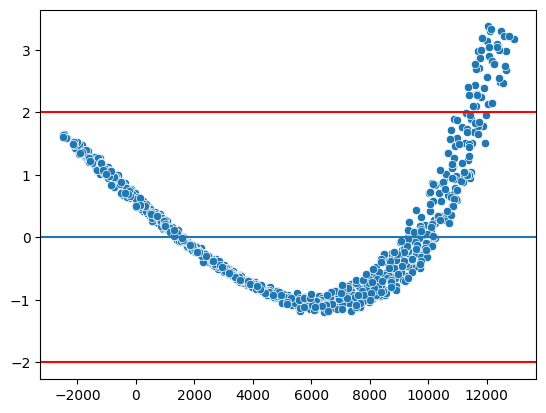

In [123]:
# Verificar a linearidade dos resíduos -> Para a escala padrão deve estar entre -2 e +2
# Verificar a homoscedasticidade -> Valores em torno da reta sem nenhuma tendência ou formato

sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2, color='red')
plt.axhline(y=2, color='red')

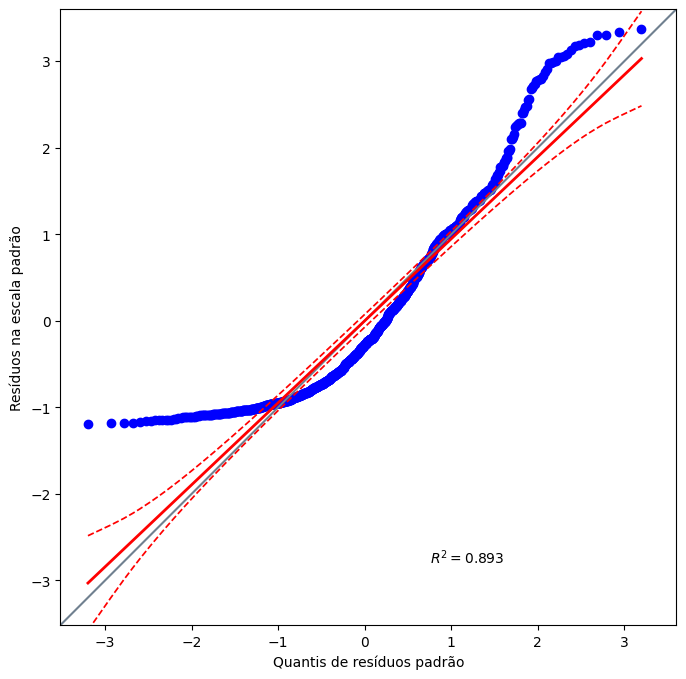

In [124]:
# Checar se resíduos seguem uma distribuição normal
import pingouin as pg

plt.figure(figsize=(14, 8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis de resíduos padrão')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [125]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

In [126]:
# Teste de normalidade - Shapiro-Wilk

stats_shapiro, p_value_shapiro = shapiro(residuos)
print(f"Shapiro-Wilk - Estatística: {stats_shapiro}, P-Value: {p_value_shapiro}")

Shapiro-Wilk - Estatística: 0.8919692179652287, P-Value: 7.013497918014801e-26


In [127]:
# Teste de normalidade - Kolmogorov-Smirnov

stats_ks, p_value_ks = kstest(residuos, 'norm')
print(f"Kolmogorov-Smirnov - Estatística: {stats_ks}, P-Value: {p_value_ks}")

Kolmogorov-Smirnov - Estatística: 0.5939999999999955, P-Value: 0.0


In [128]:
# Teste de normalidade - Lillie Fors

stats_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f"Lillie Fors - Estatística: {stats_ll}, P-Value: {p_value_ll}")

Lillie Fors - Estatística: 0.11825983774680093, P-Value: 0.0009999999999998899


## Treinar Modelo Polinomial

In [129]:
# Exemplo de criação de features polinomiais
feat_poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = feat_poly.fit_transform(X)

In [130]:
# Verificando as features de entradas
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [131]:
# Verificando as features que foram geradas
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['1', 'tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [132]:
# Bloco para treinamento do modelo

graus_polynomial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

rmse_train_values = []
rmse_test_values = []
percentual_remse_values = []
r2_scores_test_value = []

# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    # 1. Pipeline -> Padronização variáveis numéricas - tempo_na_empresa, nivel_na_empresa
    
    # Nome das colunas
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']
    # Transformer
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    # Criar um ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ])
    # Criar features Polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # 2. Pipeline -> Pré-Processamento + Treinamento
    model_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE - Treino e Teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []
    # Amazenar R² Score de Teste
    r2_scores_fold_test = []
    # Armazenar Resíduos
    residuos = []
    # Armazenar Predições
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)
        
        # Faça predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)
        
        # Calcular o RMSE para os conjuntos de treinamento e teste
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_scores_fold_train.append(rmse_train)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        rmse_scores_fold_test.append(rmse_test)
        
        # Calcular o R² para os conjuntos de teste
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_fold_test.append(r2_test)
        
        # Calcular os resíduos para conjunto de teste
        residuos_test = np.array(y_test - y_test_pred)
        residuos.append(residuos_test)
        
        y_pred_total.append(y_test_pred)  
        
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_score_final = np.mean(r2_scores_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)
    
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2_scores_test_value.append(r2_score_final)
    percentual_remse_values.append(percentual_rmse_final)

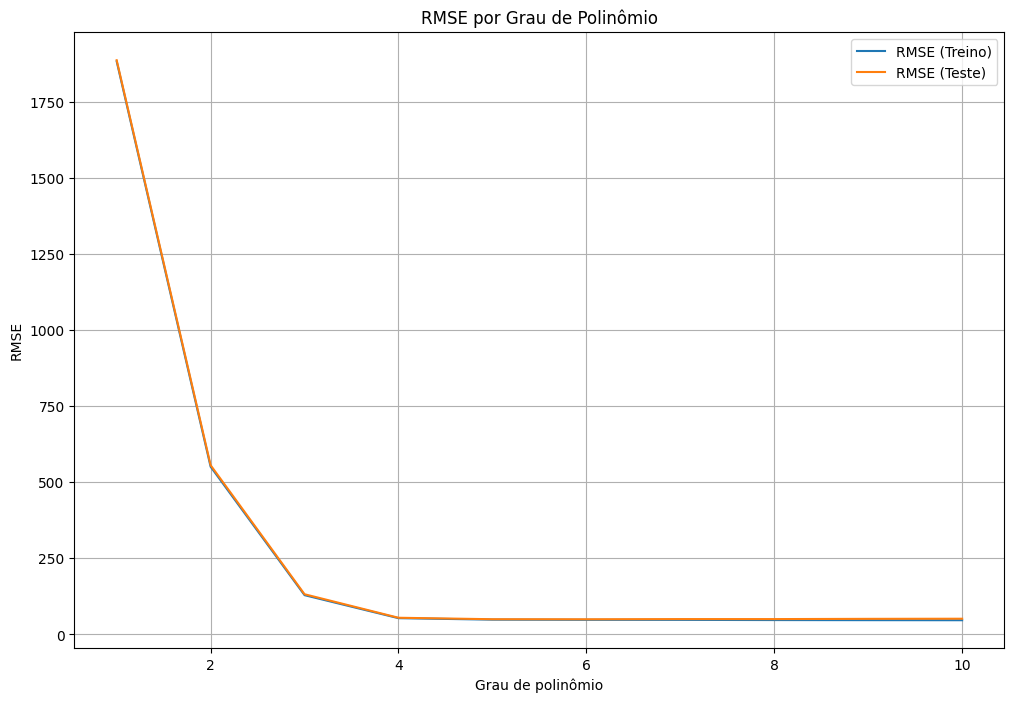

In [133]:
# Plotar gráfico para comparar RMSE por grau de polinômio

plt.figure(figsize=(12, 8))
plt.plot(graus_polynomial, rmse_train_values, label="RMSE (Treino)")
plt.plot(graus_polynomial, rmse_test_values, label="RMSE (Teste)")
plt.xlabel("Grau de polinômio")
plt.ylabel("RMSE")
plt.title("RMSE por Grau de Polinômio")
plt.legend()
plt.grid(True)
plt.show()

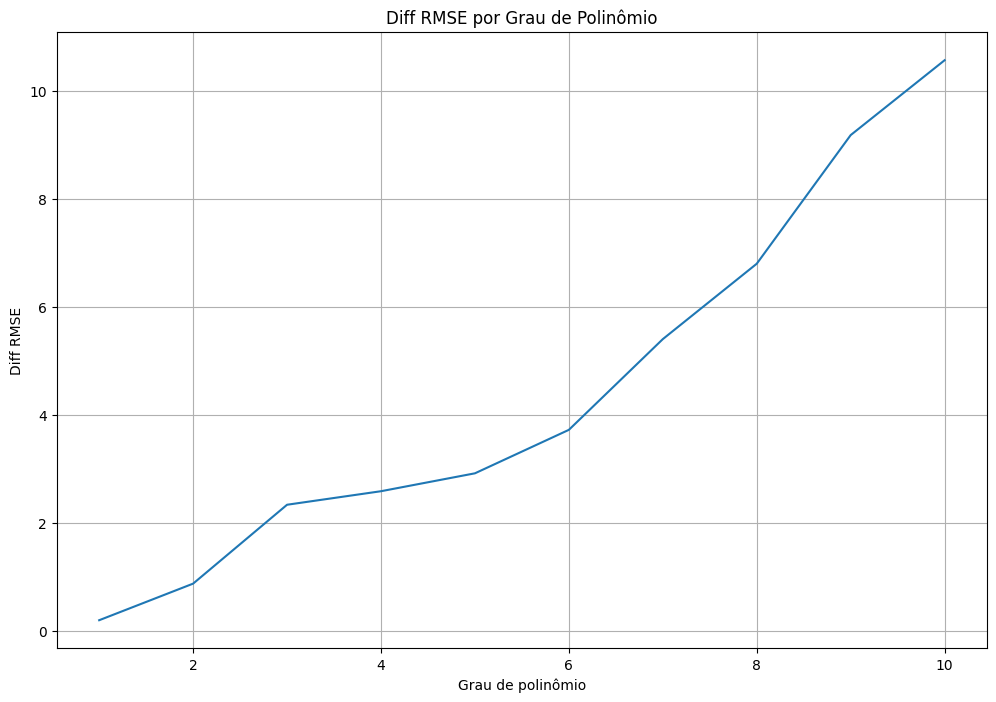

In [134]:
# Plotar gráfico para comparar percentual de diferença entre RMSE (Treino e Teste)

plt.figure(figsize=(12, 8))
plt.plot(graus_polynomial, percentual_remse_values, label="% diferença entre RMSE (Treino e Teste)")
plt.xlabel("Grau de polinômio")
plt.ylabel("Diff RMSE")
plt.title("Diff RMSE por Grau de Polinômio")
plt.grid(True)
plt.show()

### Rodando o modelo com o polinômio escolhido (4)

In [135]:
# Bloco para treinamento do modelo

graus_polynomial = [4]

rmse_train_values = []
rmse_test_values = []
percentual_remse_values = []
r2_scores_test_value = []

# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynomial:
    # 1. Pipeline -> Padronização variáveis numéricas - tempo_na_empresa, nivel_na_empresa
    
    # Nome das colunas
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']
    # Transformer
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    # Criar um ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ])
    # Criar features Polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # 2. Pipeline -> Pré-Processamento + Treinamento
    model_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE - Treino e Teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []
    # Amazenar R² Score de Teste
    r2_scores_fold_test = []
    # Armazenar Resíduos
    residuos = []
    # Armazenar Predições
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinar o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)
        
        # Faça predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)
        
        # Calcular o RMSE para os conjuntos de treinamento e teste
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_scores_fold_train.append(rmse_train)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        rmse_scores_fold_test.append(rmse_test)
        
        # Calcular o R² para os conjuntos de teste
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_fold_test.append(r2_test)
        
        # Calcular os resíduos para conjunto de teste
        residuos_test = np.array(y_test - y_test_pred)
        residuos.append(residuos_test)
        
        y_pred_total.append(y_test_pred)  
        
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2_score_final = np.mean(r2_scores_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)
    
    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2_scores_test_value.append(r2_score_final)
    percentual_remse_values.append(percentual_rmse_final)

### Análise de Métricas - Modelo Polinomial

In [136]:
# Métricas
print(f"RMSE Treino: {rmse_train_final}")
print(f"RMSE Teste: {rmse_test_final}")
print(f"RMSE - diferença (%): {percentual_rmse_final}")
print(f"R² Score Teste: {r2_score_final}")

RMSE Treino: 53.32698559565163
RMSE Teste: 54.70504352796327
RMSE - diferença (%): 2.584166190755043
R² Score Teste: 0.9998524123039415


### Análise de Resíduos - Modelo Polinomial

In [137]:
# Transformar resíduos na escala padrão -> (X - media) / desvio padrão

from scipy.stats import zscore

residuos_std = zscore(residuos)

In [138]:
residuos_std

array([-1.76658136e+00,  6.13919903e-01,  4.57932407e-01,  3.77621549e-01,
       -1.77161928e+00, -2.13372467e+00, -2.88053498e-01, -1.15486201e+00,
        1.26076256e+00, -1.38932876e+00, -1.63659072e-01,  9.49916278e-01,
        1.10428797e+00, -1.69277005e+00, -1.55137077e+00,  6.50212053e-01,
        2.39650670e+00, -5.48674224e-01, -4.71815369e-01, -4.93214903e-01,
       -9.93275437e-01,  4.37069649e-01, -2.35827600e-01,  4.45720599e-01,
        1.40041227e-01, -2.28929917e+00,  3.58302195e-01,  6.15006495e-01,
        1.42514234e+00, -1.40851950e+00,  1.28177409e+00, -1.47234024e-01,
       -3.60957871e-01, -9.30096879e-02,  3.81531150e-01,  1.24092430e-01,
       -3.96949408e-01,  8.01984667e-01, -1.66729377e+00, -3.61968959e-01,
        1.09965292e+00,  4.53175371e-01, -3.37795185e-01, -6.12203426e-01,
        1.86697658e-01, -1.00712904e+00,  3.94042102e-01,  1.06437582e+00,
       -2.25733503e+00,  1.51520710e+00, -4.44535131e-01,  2.39420946e+00,
       -3.94795656e-01, -

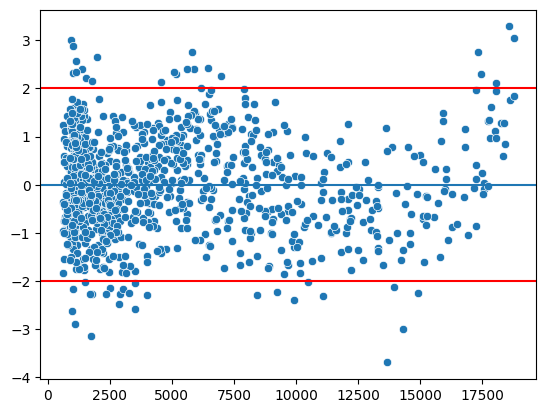

In [139]:
# Verificar a linearidade dos resíduos -> Para a escala padrão deve estar entre -2 e +2
# Verificar a homoscedasticidade -> Valores em torno da reta sem nenhuma tendência ou formato

sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2, color='red')
plt.axhline(y=2, color='red')

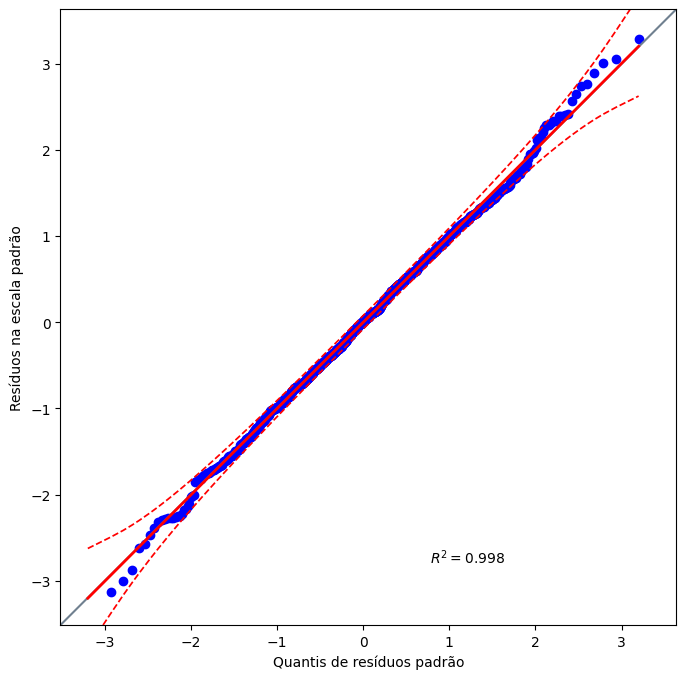

In [140]:
# Checar se resíduos seguem uma distribuição normal
import pingouin as pg

plt.figure(figsize=(14, 8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis de resíduos padrão')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [141]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

In [142]:
# Teste de normalidade - Shapiro-Wilk

stats_shapiro, p_value_shapiro = shapiro(residuos)
print(f"Shapiro-Wilk - Estatística: {stats_shapiro}, P-Value: {p_value_shapiro}")

Shapiro-Wilk - Estatística: 0.9986951372205318, P-Value: 0.6852797159657319


In [143]:
# Teste de normalidade - Kolmogorov-Smirnov

stats_ks, p_value_ks = kstest(residuos, 'norm')
print(f"Kolmogorov-Smirnov - Estatística: {stats_ks}, P-Value: {p_value_ks}")

Kolmogorov-Smirnov - Estatística: 0.48237446499535763, P-Value: 1.2202460105220945e-214


In [144]:
# Teste de normalidade - Lillie Fors

stats_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f"Lillie Fors - Estatística: {stats_ll}, P-Value: {p_value_ll}")

Lillie Fors - Estatística: 0.013637346894976088, P-Value: 0.9566270022046808


# Realizar Predições Individuais

In [151]:
input_features = {
    'tempo_na_empresa': 80,
    'nivel_na_empresa': 10,
}

pred_df = pd.DataFrame(input_features, index=[1])

In [152]:
model_poly.predict(pred_df)

array([5977.64164035])

In [153]:
import joblib

In [154]:
# Salvar o model_poly
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']